In [1]:
import pandas as pd
import numpy as np
import sqlite3

In [2]:
#Creating pandas object
db = pd.read_csv('../data/bigml.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
db.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
db['churn'] = db['churn'].astype(int)

In [6]:
call_charge_mins = db.drop(['state', 'account length', 'area code', 'phone number', 'international plan', 'voice mail plan', 'number vmail messages', 'customer service calls', 'churn'], axis=1)

In [7]:
call_charge_mins.head()

,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge
0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70
1,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70
2,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29
3,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78
4,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73


In [8]:
international = db.drop(['state', 'account length', 'area code', 'phone number', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge'], axis=1)

In [9]:
int_plan_vm_dummies = pd.get_dummies(international[ ['international plan','voice mail plan']])

In [10]:
int_plan_vm_dummies.head()

,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,1,0,0,1
1,1,0,0,1
2,1,0,1,0
3,0,1,1,0
4,0,1,1,0


In [11]:
international.head()

,international plan,voice mail plan,number vmail messages,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,no,yes,25,10.0,3,2.70,1,0
1,no,yes,26,13.7,3,3.70,1,0
2,no,no,0,12.2,5,3.29,0,0
3,yes,no,0,6.6,7,1.78,2,0
4,yes,no,0,10.1,3,2.73,3,0


In [12]:
local = db.filter(['state', 'account length', 'area code', 'churn'])

In [13]:
local.head()

,state,account length,area code,churn
0,KS,128,415,0
1,OH,107,415,0
2,NJ,137,415,0
3,OH,84,408,0
4,OK,75,415,0


In [14]:
#plan:
# local = maybe competitors have higher coverage or better deals in certain areas
# international = maybe more languages need to be represented in customer service for int users, maybe international charges are too expensive
# calls_charge = for total usage maybe the rates for high amount users are too expensive

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
FunctionTransformer, PolynomialFeatures

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier


from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.metrics import plot_roc_curve

In [41]:
ss = StandardScaler()
ss.fit(call_charge_mins)

StandardScaler()

In [42]:
call_scaled = pd.DataFrame(ss.transform(call_charge_mins), columns = call_charge_mins.columns)

In [43]:
call_scaled.head()

,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge
0,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690
1,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169
2,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156
3,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401
4,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885


In [44]:
numtest = selector(dtype_include=np.number)

In [45]:
X = pd.concat( [call_scaled, int_plan_vm_dummies], axis=1)

In [46]:
X.head()

,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,international plan_no,international plan_yes,voice mail plan_no,voice mail plan_yes
0,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,1,0,0,1
1,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,1,0,0,1
2,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,1,0,1,0
3,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0,1,1,0
4,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,0,1,1,0


In [47]:
y = db['churn']

In [48]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int32

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [50]:
dummy_model = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

In [51]:
dummy_model.score(X_test, y_test)

0.8501199040767387

In [52]:
dummy_model.score(X_train, y_train)

0.8567426970788315

In [53]:
y_train.value_counts(normalize=True)

0    0.856743
1    0.143257
Name: churn, dtype: float64

In [54]:
cv_results = cross_val_score(dummy_model, X_train, y_train, cv=5)

In [55]:
cv_results

array([0.858     , 0.856     , 0.856     , 0.856     , 0.85771543])

In [56]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [57]:
dummy_model_results = ModelWithCV(
    model=dummy_model,
    model_name = 'Dummy',
    X=X_train,
    y=y_train
)

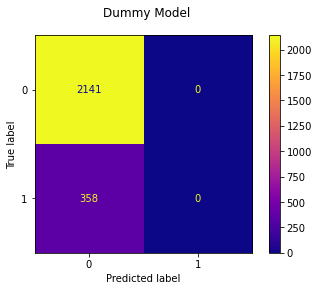

In [58]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_train, y_train, ax=ax, cmap="plasma");

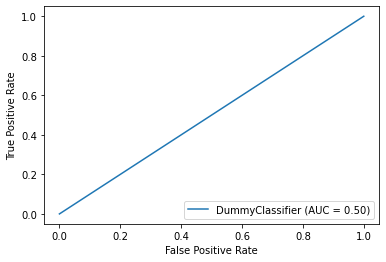

In [59]:
plot_roc_curve(dummy_model, X_train, y_train);

In [60]:
simple_logreg_model = LogisticRegression(penalty='none', random_state=42).fit(X_train, y_train)

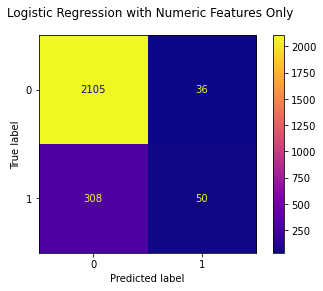

In [61]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Numeric Features Only")

plot_confusion_matrix(simple_logreg_model, X_train, y_train, ax=ax, cmap="plasma");

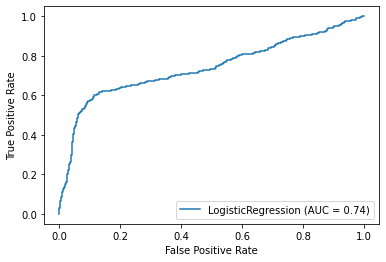

In [62]:
# ROC
plot_roc_curve(simple_logreg_model, X_train, y_train)

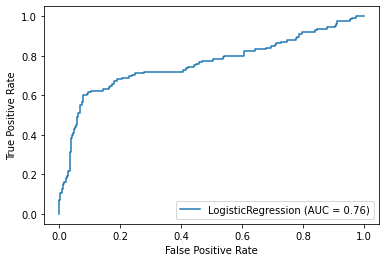

In [87]:
# ROC
plot_roc_curve(simple_logreg_model, X_test, y_test)

In [63]:
log_reg_model = LogisticRegression(penalty='none',random_state=42).fit(X_train, y_train)

In [64]:
logreg_model_more_iterations = LogisticRegression(penalty='none',
                                                  random_state=42,
                                                  max_iter=1000)

In [65]:
logreg_model_more_iterations.fit(X_train, y_train)

LogisticRegression(max_iter=1000, penalty='none', random_state=42)

In [66]:
logreg_model_higher_tolerance = LogisticRegression(penalty='none',
                                                  random_state=42,
                                                  tol=25)

In [67]:
logreg_model_higher_tolerance.fit(X_train, y_train)

LogisticRegression(penalty='none', random_state=42, tol=25)

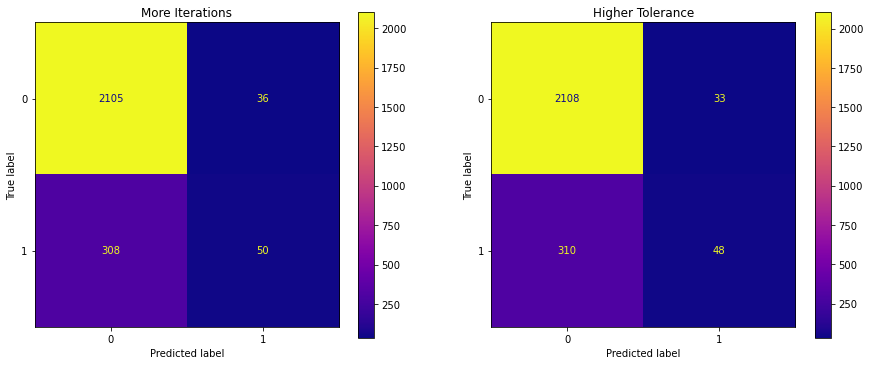

In [68]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train, y_train,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train, y_train,
                      ax=axes[1], cmap="plasma");

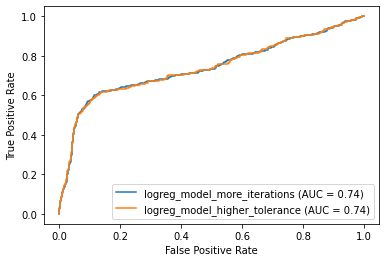

In [69]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_model_more_iterations, X_train, y_train, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(logreg_model_higher_tolerance, X_train, y_train, 
               name='logreg_model_higher_tolerance', ax=ax);

In [70]:
# Build a grid
grid = {
    'penalty' : ['none','l1','l2'],
    'solver' : ['lbfgs','liblinear'],
    'max_iter' : [10,100,1000],
    'C' : [0.001, 0.01, 0.1,1 ],
    'tol' : [.0001, .001, .01, .1]
}

In [71]:
# Instantiate the object

gs = GridSearchCV(LogisticRegression(), param_grid=grid, verbose=1)

In [73]:
# Fit

gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\U

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: Converge

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: Converge

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: Converge

C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py", line 453, in _check_solver
    raise ValueError(
ValueError: penalty='none' is not supported for the liblinear solver

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\happy\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_s

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': [10, 100, 1000],
                         'penalty': ['none', 'l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear'],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [74]:
# Parameters

gs.best_params_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.1}

In [76]:
# Score
gs.score(X_train, y_train)

0.8631452581032413

In [77]:
gs.score(X_test, y_test)

0.8621103117505995

In [78]:
# Estimator

gs_model = gs.best_estimator_

CV Results for `gs_model` model:
            0.86075 ± 0.01219 accuracy
        


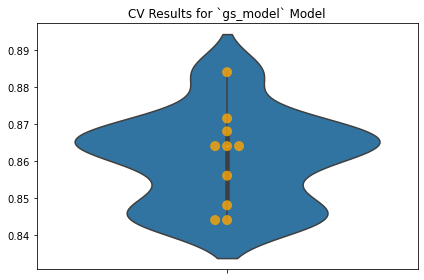

In [80]:
# Evaluate
gs_model_results = ModelWithCV(
                        model=gs_model,
                        model_name='gs_model',
                        X=X_train, 
                        y=y_train
)

fig, ax = plt.subplots()

ax = gs_model_results.plot_cv(ax)
plt.tight_layout();

gs_model_results.print_cv_summary()

In [82]:
# Create a way to categorize our different models
model_candidates = [
    {
        'name':'dummy_model'
        ,'model':dummy_model
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'simple_logreg_model'
        ,'model':simple_logreg_model
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_more_iterations'
        ,'model':logreg_model_more_iterations
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_higher_tolerance'
        ,'model':logreg_model_higher_tolerance
        ,'X_test':X_test
        ,'y_test':y_test
    },
    {
        'name':'gs_model'
        ,'model':gs_model
        ,'X_test':X_test
        ,'y_test':y_test
    }
]

In [83]:
final_scores_dict = {
    "Model Name": [candidate.get('name') for candidate in model_candidates],
    "Mean Accuracy": [
        candidate.get('model').score(
                                candidate.get('X_test'), 
                                candidate.get('y_test')
        ) 
        for candidate in model_candidates
    ]
    
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

,Mean Accuracy
Model Name,
dummy_model,0.850120
simple_logreg_model,0.860911
logreg_model_more_iterations,0.860911
logreg_model_higher_tolerance,0.860911
gs_model,0.862110


In [85]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

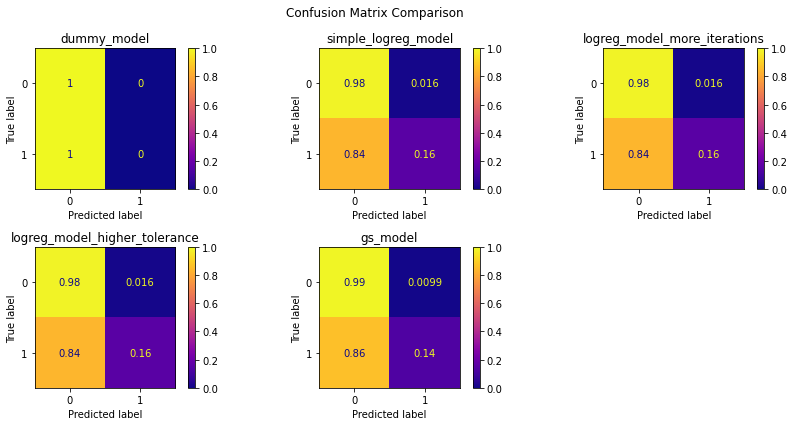

In [86]:
nrows = 2
ncols = math.ceil(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(12, 6)
)
fig.suptitle("Confusion Matrix Comparison")

# Turn off all the axes (in case nothing to plot); turn on while iterating over
[ax.axis('off') for ax in axes.ravel()]


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 3
    col = i % 3
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    ax.set_axis_on() 
    cm_display = plot_confusion_matrix(
                    candidate.get('model'),
                    candidate.get('X_test'),
                    candidate.get('y_test'),
                    normalize='true',
                    cmap='plasma',
                    ax=ax,
                    
    )
    cm_display.im_.set_clim(0, 1)

plt.tight_layout()